In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [2]:
all_data_daily_path = 'merged_data_granualityBased/all_data_(daily).csv'

In [3]:
all_data_daily = pd.read_csv(all_data_daily_path)

In [4]:
all_data_daily

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
0,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,0.151,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852
1,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,0.115,0.082,0.077,0.062,0.060,0.057,0.0226,0.086857,0.703333,0.4552
2,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,0.036,0.024,0.021,0.019,0.024,0.022,0.1174,0.029714,0.152333,0.0300
3,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,0.151,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852
4,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,0.115,0.082,0.077,0.062,0.060,0.057,0.0226,0.086857,0.703333,0.4552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,2022-12-30,297210.1750,5.2,2.2,24,8.5,46,7,12.9,22,...,0.198,0.175,0.196,0.163,0.153,0.168,-0.1260,0.176143,1.403000,0.9916
8762,2022-12-30,297210.1750,5.2,2.2,24,8.5,46,7,12.9,22,...,0.037,0.027,0.024,0.020,0.018,0.020,0.1200,0.034857,0.187333,0.0410
8763,2022-12-31,274811.7625,21.2,3.6,5,14.0,104,5,15.9,19,...,0.235,0.201,0.219,0.183,0.171,0.189,-0.0060,0.210857,1.590667,1.0328
8764,2022-12-31,274811.7625,21.2,3.6,5,14.0,104,5,15.9,19,...,0.198,0.175,0.196,0.163,0.153,0.168,-0.1260,0.176143,1.403000,0.9916


In [5]:
all_data_daily["Population"] = all_data_daily["Population"].str.replace(',', '').astype(float)

In [6]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [7]:
adf_test(all_data_daily["loadConsumption"])

ADF Statistic: -3.8920891201275842
p-value: 0.002093844377001172
Data is stationary


In [8]:
#all_data_daily = pd.get_dummies(all_data_daily, columns=["day_of_week"], drop_first=True)

In [9]:
selected_features = ['Population', 'GDP','AveragePrice_Electricity_Household', 'Totaal windenergie (MWh)',
                     'TotalSolarEnergy (MWh)', 'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                     'Week', 'Year', 'HourlyMinTemperature', 'loadConsumption']

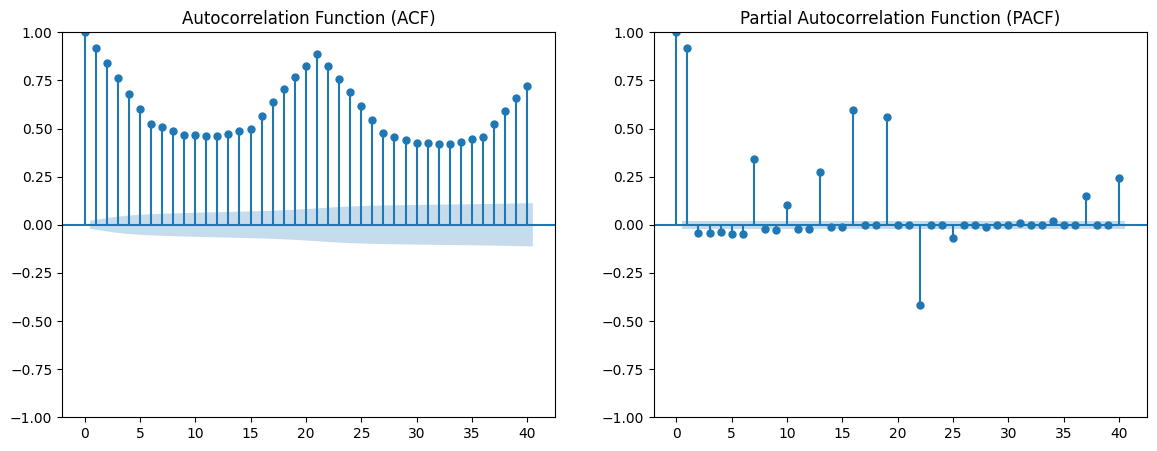

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure date is in datetime format and set as index
all_data_daily['date'] = pd.to_datetime(all_data_daily['date'])
all_data_daily.set_index('date', inplace=True)

# Extract the target variable for ARIMA
load_consumption = all_data_daily['loadConsumption']

# Plot ACF and PACF to determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(load_consumption, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(load_consumption, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


In [11]:
data = all_data_daily.copy()

In [12]:
data = data[selected_features]

In [13]:
data

,Population,GDP,AveragePrice_Electricity_Household,Totaal windenergie (MWh),TotalSolarEnergy (MWh),TotalRes(incl.Stat.Transfer) (MWh),HourlyMaxTemperature,Week,Year,HourlyMinTemperature,loadConsumption
date,,,,,,,,,,,
2015-01-01,1690.0,174803.35,0.1400,6916722.00,1424178.06,32553593.76,4.7,1,2015,10,275667.0000
2015-01-01,1690.0,174803.35,0.0226,6916722.00,1424178.06,32553593.76,4.7,1,2015,10,275667.0000
2015-01-01,1690.0,174803.35,0.1174,6916722.00,1424178.06,32553593.76,4.7,1,2015,10,275667.0000
2015-01-02,1690.0,174803.35,0.1400,6916722.00,1424178.06,32553593.76,10.1,1,2015,44,319026.0000
2015-01-02,1690.0,174803.35,0.0226,6916722.00,1424178.06,32553593.76,10.1,1,2015,44,319026.0000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,1759.0,248426.55,-0.1260,21404060.12,16981246.96,76588390.48,12.9,52,2022,46,297210.1750
2022-12-30,1759.0,248426.55,0.1200,21404060.12,16981246.96,76588390.48,12.9,52,2022,46,297210.1750
2022-12-31,1759.0,248426.55,-0.0060,21404060.12,16981246.96,76588390.48,15.9,52,2022,104,274811.7625


In [14]:
data.columns

Index(['Population', 'GDP', 'AveragePrice_Electricity_Household',
       'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature', 'Week',
       'Year', 'HourlyMinTemperature', 'loadConsumption'],
      dtype='object')

In [15]:
data = data.reset_index()

In [16]:
# Convert 'date' to datetime format
data["date"] = pd.to_datetime(data["date"])

In [17]:
#print(data.dtypes)

In [18]:
#data.isna().sum()


### Create Time Features

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar  # Adjust based on your region

def create_time_features(data, target_column='loadConsumption'):
    """
    Generate time-based features for time series forecasting.
    
    Parameters:
    - data (DataFrame): The original dataset containing a 'date' column.
    - target_column (str): The target variable for rolling features.
    
    Returns:
    - data (DataFrame): The updated DataFrame with new features.
    """

    # Ensure 'date' is a datetime index
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')

    # Create 'is_weekend' feature (1 if Saturday/Sunday, else 0)
    data['is_weekend'] = data.index.weekday.isin([5, 6]).astype(int)

    # Create 'day_of_week' feature (0 = Monday, 6 = Sunday)
    data['day_of_week'] = data.index.weekday

    # Create 'is_holiday' feature (1 if a holiday, else 0)
    cal = USFederalHolidayCalendar()  # You can replace with a different holiday calendar
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['is_holiday'] = data.index.isin(holidays).astype(int)

    # Create rolling mean features for the target variable
    data['rolling_7'] = data[target_column].rolling(window=7, min_periods=1).mean()
    data['rolling_30'] = data[target_column].rolling(window=30, min_periods=1).mean()

    return data


In [20]:
data = create_time_features(data)

In [21]:
# Compute rolling means with min_periods=1 to avoid NaN at the beginning
data['rolling_7'] = data['loadConsumption'].rolling(window=7, min_periods=1).mean()
data['rolling_30'] = data['loadConsumption'].rolling(window=30, min_periods=1).mean()

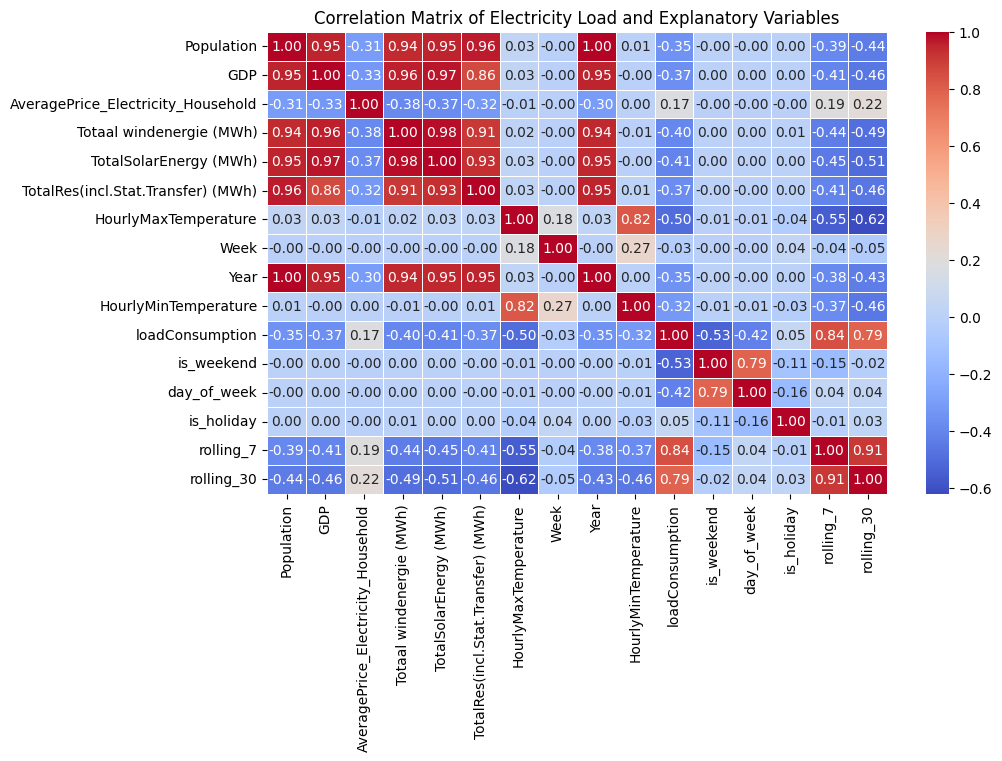

In [22]:
numeric_cols = data.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Electricity Load and Explanatory Variables")
plt.show()


## SARIMAX

In [23]:
df_sarimax = data
df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


C:\Users\mahmo\AppData\Local\Temp\ipykernel_10268\4025944559.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


In [24]:
df_sarimax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8766 entries, 2015-01-01 to 2022-12-31
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Population                          8766 non-null   float64
 1   GDP                                 8766 non-null   float64
 2   AveragePrice_Electricity_Household  8766 non-null   float64
 3   Totaal windenergie (MWh)            8766 non-null   float64
 4   TotalSolarEnergy (MWh)              8766 non-null   float64
 5   TotalRes(incl.Stat.Transfer) (MWh)  8766 non-null   float64
 6   HourlyMaxTemperature                8766 non-null   float64
 7   Week                                8766 non-null   int64  
 8   Year                                8766 non-null   int64  
 9   HourlyMinTemperature                8766 non-null   int64  
 10  loadConsumption                     8766 non-null   float64
 11  is_weekend               

In [25]:
df_sarimax.columns

Index(['Population', 'GDP', 'AveragePrice_Electricity_Household',
       'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature', 'Week',
       'Year', 'HourlyMinTemperature', 'loadConsumption', 'is_weekend',
       'day_of_week', 'is_holiday', 'rolling_7', 'rolling_30'],
      dtype='object')

In [26]:
from pmdarima import auto_arima

# Run Auto-ARIMA to find optimal parameters
auto_model = auto_arima(df_sarimax["loadConsumption"], seasonal=True, m=7, 
                        exogenous=df_sarimax[['Population', 'GDP', 'AveragePrice_Electricity_Household',
                                               'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
                                               'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                                              'Week','Year', 'HourlyMinTemperature', 'is_weekend','day_of_week',
                                               'is_holiday', 'rolling_7', 'rolling_30']], 
                        stepwise=True, trace=True)

auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=191154.514, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=191142.512, Time=0.13 sec


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=191146.512, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=191146.516, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=191140.512, Time=0.10 sec


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=191144.512, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=191144.512, Time=0.32 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=191146.512, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=191144.512, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=191144.516, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=191146.516, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 3.444 seconds


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8766
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -95569.256
Date:                Wed, 26 Feb 2025   AIC                         191140.512
Time:                        20:43:26   BIC                         191147.591
Sample:                             0   HQIC                        191142.924
                               - 8766                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.73e+08    1.2e+06    143.955      0.000    1.71e+08    1.75e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21832.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
# Train-test split
train_size = int(len(df_sarimax) * 0.8)
train, test = df_sarimax.iloc[:train_size], df_sarimax.iloc[train_size:]

In [29]:
# Define endogenous (target) and exogenous (features)
endog_train = train["loadConsumption"]
exog_train = train[['Population', 'GDP', 'AveragePrice_Electricity_Household',
                    'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
                    'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                     'Week','Year', 'HourlyMinTemperature', 'is_weekend','day_of_week',
                     'is_holiday', 'rolling_7', 'rolling_30']]

endog_test = test["loadConsumption"]
exog_test = test[['Population', 'GDP', 'AveragePrice_Electricity_Household',
                    'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
                    'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                     'Week','Year', 'HourlyMinTemperature', 'is_weekend','day_of_week',
                     'is_holiday', 'rolling_7', 'rolling_30']]

In [30]:
# Use Auto-ARIMA parameters if available
best_p, best_d, best_q = auto_model.order  
best_P, best_D, best_Q, best_s = auto_model.seasonal_order

In [31]:
# Train SARIMAX model
sarimax_model = SARIMAX(endog_train, exog=exog_train, 
                        order=(best_p, best_d, best_q), 
                        seasonal_order=(best_P, best_D, best_Q, best_s),  
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_fit = sarimax_model.fit()

# Forecast
forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# Prevent negative values
forecast = np.maximum(forecast, 0)


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

In [32]:
print("Forecast index type:", type(forecast.index))
print("endog_test index type:", type(endog_test.index))

Forecast index type: <class 'pandas.core.indexes.range.RangeIndex'>
endog_test index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [33]:
forecast.index = endog_test.index  # Align forecast index with actual values

In [34]:
from sklearn.metrics import r2_score, mean_absolute_error

# RMSE
rmse_sarimax = np.sqrt(((forecast - endog_test) ** 2).mean())

# R^2 Score
r2_sarimax = r2_score(endog_test, forecast)

# Mean Absolute Percentage Error (MAPE)
mape_sarimax = np.mean(np.abs((endog_test - forecast) / endog_test)) * 100

# Mean Absolute Error (MAE)
mae_sarimax = mean_absolute_error(endog_test, forecast)

# Print Metrics
print(f" RMSE: {rmse_sarimax}")
print(f" R2: {r2_sarimax}")
print(f" MAPE: {mape_sarimax}")
print(f" MAE: {mae_sarimax}")

# Save metrics to DataFrame
metrics_sarimax_df = pd.DataFrame({
    "Metric": ["RMSE", "R^2 Score", "MAPE", "MAE"],
    "Value": [rmse_sarimax, r2_sarimax, mape_sarimax, mae_sarimax]
})


 RMSE: 62960.58863017145
 R2: -2.9581467770260024
 MAPE: 18.85532429814333
 MAE: 51467.48861168685


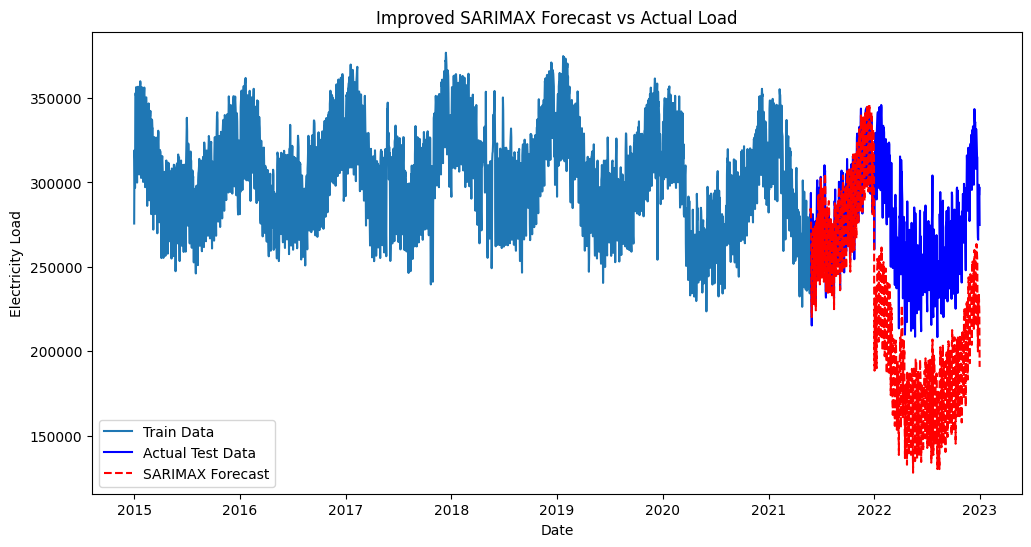

In [35]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["loadConsumption"], label="Train Data")
plt.plot(test.index, test["loadConsumption"], label="Actual Test Data", color="blue")
plt.plot(test.index, forecast, label="SARIMAX Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.title("Improved SARIMAX Forecast vs Actual Load")
plt.legend()
plt.show()

## Test with different models

In [36]:
## prepare data
def prepare_data(data, target_column, exog_columns, test_size=0.2, scale=False, lstm=False):
    """Prepares the dataset for training/testing and handles missing values."""
    
    # Define target variable
    y = data[target_column]
    X = data[exog_columns]

    # Convert boolean columns to int
    for col in X.select_dtypes(include=['bool']).columns:
        X[col] = X[col].astype(int)

    # Handle missing values
    X.fillna(X.mean(), inplace=True)
    y.fillna(y.mean(), inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    
    # Apply MinMaxScaler for LSTM (if required)
    if scale:
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train = scaler_x.fit_transform(X_train)
        X_test = scaler_x.transform(X_test)
        y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
        y_test = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()
        return X_train, X_test, y_train, y_test, scaler_x, scaler_y
    
    return X_train, X_test, y_train, y_test


In [37]:
# Model Training & Evaluation Function 
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name, scaler_y=None):
    """Trains a model, makes predictions, and evaluates performance."""
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make Predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions for LSTM (if applicable)
    if scaler_y:
        y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
    
    # Model Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  MAE: {mae:.4f}\n")
    
    return {"Model": model_name, "RMSE": rmse, "R² Score": r2, "MAPE": mape, "MAE": mae}, y_test, y_pred

In [38]:
def plot_results(y_test, y_pred, model_name):
    """Plots actual vs predicted values for a single model."""
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual", color="blue")
    plt.plot(y_pred, label=f"Predicted ({model_name})", color="red", linestyle="dashed")
    
    plt.xlabel("Time")
    plt.ylabel("Load Consumption")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.legend()
    plt.show()


In [42]:
target_column = 'loadConsumption'
y = data[target_column]

# Define independent variables (exclude target)
exog_columns = ['Population', 'GDP', 'AveragePrice_Electricity_Household',
                'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
                'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                'is_weekend', 'is_holiday', 'day_of_week', 'rolling_7', 'rolling_30',
                'Week', 'Year', 'HourlyMinTemperature']

X = data[exog_columns]

# Convert boolean columns to int
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

In [45]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

## Multi Linaer Regression

In [46]:
## MLR
mlr_model = LinearRegression()
metrics_mlr, y_test, y_pred_mlr = train_and_evaluate(mlr_model, X_train, X_test, y_train, y_test, "Multiple Linear Regression")

Model: Multiple Linear Regression
  RMSE: 9331.8890
  R² Score: 0.9130
  MAPE: 2.66%
  MAE: 7241.3246



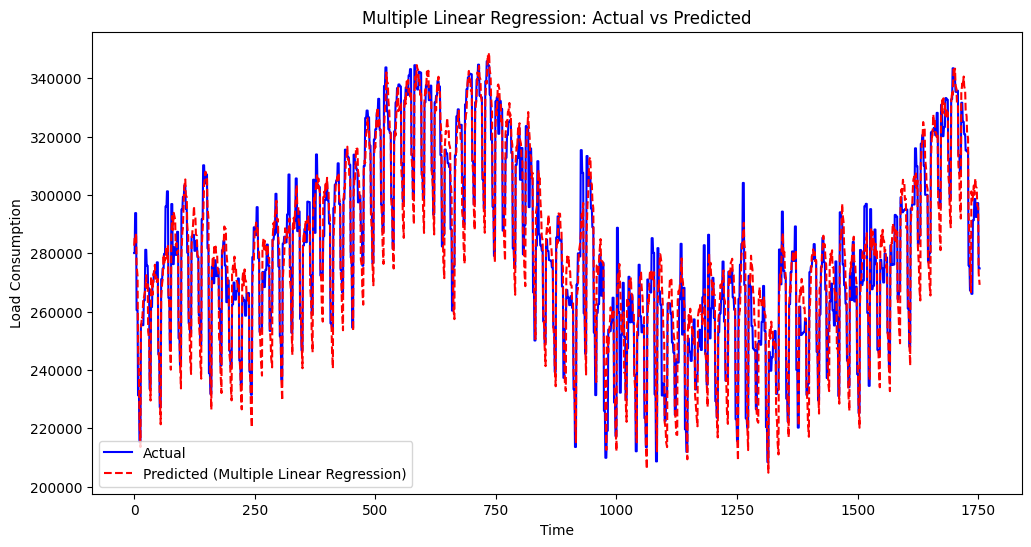

In [50]:
# Ensure y_test index is correctly formatted
y_test.index = pd.to_datetime(y_test.index)

# Align predictions to y_test index
y_test_aligned = y_test.reset_index(drop=True)
y_pred_aligned = pd.Series(y_pred_mlr, index=y_test_aligned.index)

# plot 
plot_results(y_test_aligned, y_pred_aligned, "Multiple Linear Regression")


## LSTM

In [51]:
def create_sequences(X, y, time_steps=10):
    """
    Convert a dataset into sequences for LSTM input.

    Parameters:
    - X: Features (numpy array or dataframe)
    - y: Target values (numpy array or dataframe)
    - time_steps: Number of time steps for each sequence

    Returns:
    - X_seq: Numpy array of shape (samples, time_steps, features)
    - y_seq: Numpy array of target values
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    
    return np.array(X_seq), np.array(y_seq)


In [52]:
# Prepare data for LSTM (if not done already)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_x, scaler_y = prepare_data(
    data, target_column, exog_columns, scale=True
)

# Convert data into LSTM sequences
time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Define LSTM Model
lstm_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Evaluate LSTM
y_pred_lstm_scaled = lstm_model.predict(X_test_seq)
metrics_lstm, y_test_actual, y_pred_lstm = train_and_evaluate(lstm_model, X_train_seq, X_test_seq, y_train_seq, y_test_seq, "LSTM", scaler_y)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_10268\1426705652.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Epoch 1/50
219/219 [==============================] - 6s 18ms/step - loss: 0.0335 - val_loss: 0.0118
Epoch 2/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0141 - val_loss: 0.0114
Epoch 3/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 4/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 5/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 6/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 7/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 8/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 9/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0074 - val_loss: 0.0115
Epoch 10/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0069 - val_lo

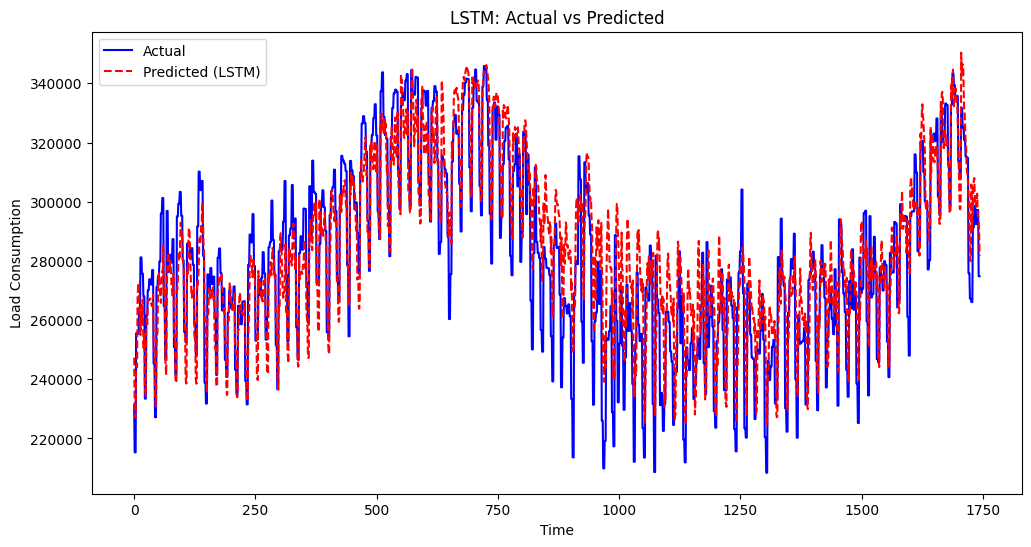

In [53]:
# Convert LSTM predictions to 1D
y_pred_lstm = y_pred_lstm_scaled.flatten()

# Inverse transform predictions and actual values
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# Ensure alignment in length
y_pred_lstm = y_pred_lstm[:len(y_test_actual)]

# Plot LSTM predictions
plot_results(y_test_actual, y_pred_lstm, "LSTM")


## Ramdom Forest

In [54]:
# Apply Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
metrics_rf, y_test, y_pred_rf = train_and_evaluate(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

Model: Random Forest
  RMSE: 11582.3469
  R² Score: 0.8660
  MAPE: 3.25%
  MAE: 8691.4863



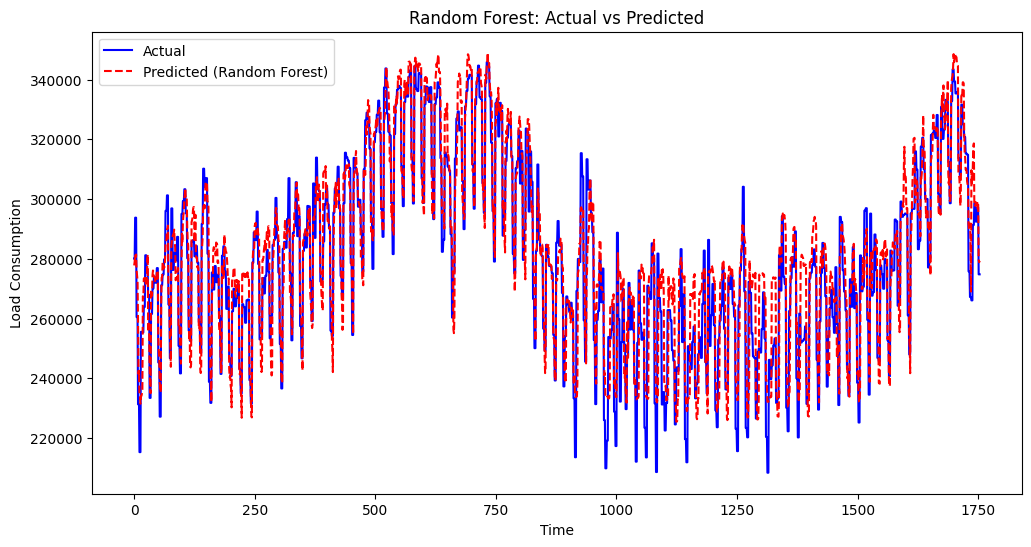

In [55]:
# Ensure both actual and predicted values have the same index
y_test_aligned = y_test.reset_index(drop=True)
y_pred_rf_aligned = pd.Series(y_pred_rf, index=y_test_aligned.index)

# Plot 
plot_results(y_test_aligned, y_pred_rf_aligned, "Random Forest")


## Enemble Model

In [56]:
# Define Ensemble Model
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42))
])

metrics_ensemble, y_test, y_pred_ensemble = train_and_evaluate(ensemble_model, X_train, X_test, y_train, y_test, "Ensemble Model")

Model: Ensemble Model
  RMSE: 10405.1367
  R² Score: 0.8919
  MAPE: 2.95%
  MAE: 7890.8843



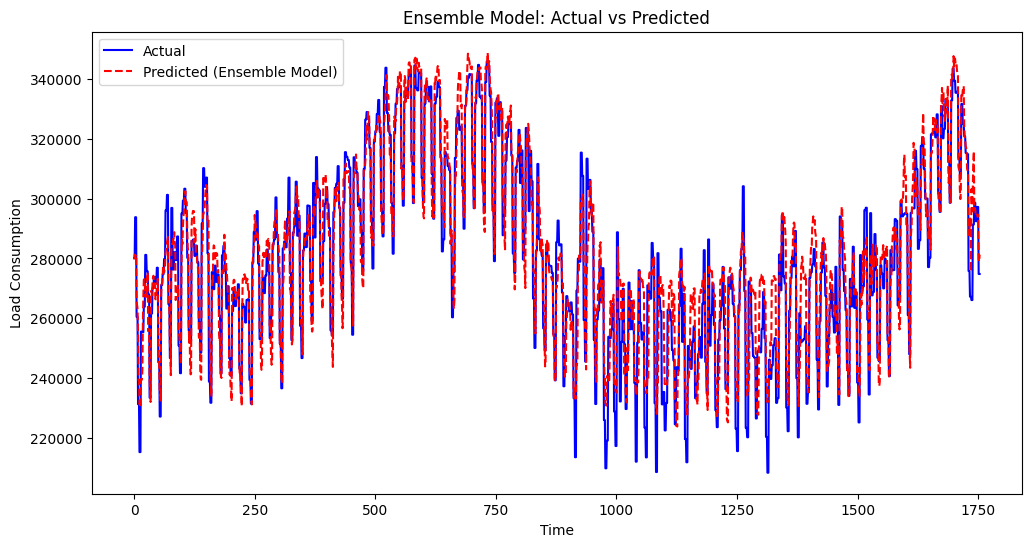

In [57]:
# Ensure both actual and predicted values have the same index
y_test_aligned = y_test.reset_index(drop=True)
y_pred_ensemble_aligned = pd.Series(y_pred_ensemble, index=y_test_aligned.index)

# Plot again
plot_results(y_test_aligned, y_pred_ensemble_aligned, "Ensemble Model")

## XGBoost

In [58]:
# Apply XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
metrics_xgb, y_test, y_pred_xgb = train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

Model: XGBoost
  RMSE: 10256.6147
  R² Score: 0.8950
  MAPE: 2.95%
  MAE: 7896.2659



In [59]:
# Define dataset details
target_column = 'loadConsumption'
exog_columns = ['Population', 'GDP', 'AveragePrice_Electricity_Household',
                'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
                'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
                'is_weekend', 'is_holiday', 'day_of_week', 'rolling_7', 'rolling_30',
                'Week', 'Year', 'HourlyMinTemperature']

# Prepare data (for non-LSTM models)
X_train, X_test, y_train, y_test = prepare_data(data, target_column, exog_columns)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_10268\1426705652.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


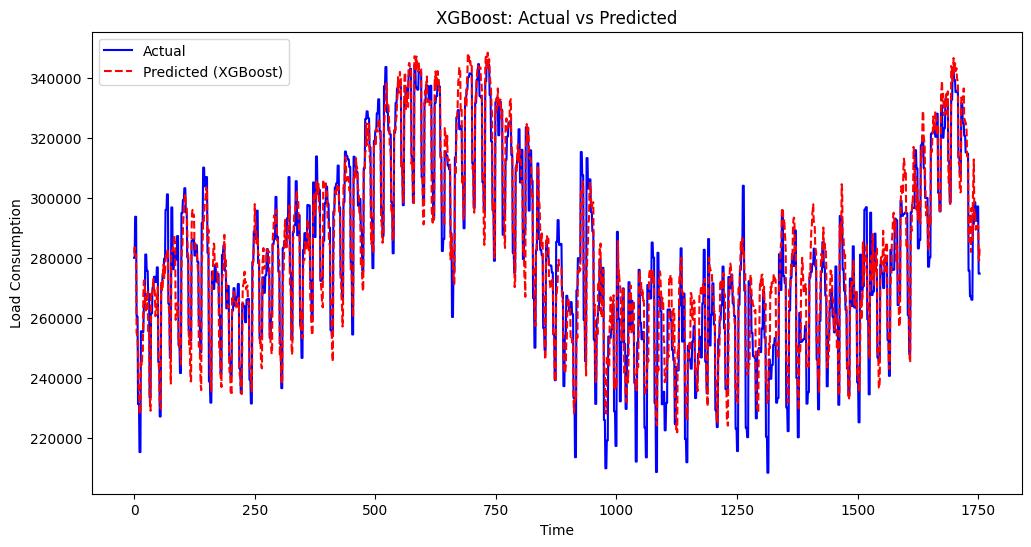

In [60]:
# Ensure XGBoost predictions align with actual values
y_test_aligned = y_test.reset_index(drop=True)
y_pred_xgb_aligned = pd.Series(y_pred_xgb, index=y_test_aligned.index)

# Plot XGBoost predictions
plot_results(y_test_aligned, y_pred_xgb_aligned, "XGBoost")


## Two stage Prediction

Stage 1: 
Predict long-term (yearly) prediction of energy demand based on:
- GDP
- Population
- Energy_Price
- Renewable Energy Share:
      1.Renewable Energy Total Share
      2. Solar Energy Shae
      3. Wind Energy Share

Stage 2: 
Predict daily demand, using 5 most important feautres, yearly predtions, and monthly change rate in consumption.
- max_depth = 10 to prevent overfiting


##### Features set that will get used through the different stage is the same feature set used above in the different models

['Population', 'GDP', 'AveragePrice_Electricity_Household',
 'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)',
'TotalRes(incl.Stat.Transfer) (MWh)', 'HourlyMaxTemperature',
/'Week','Year', 'HourlyMinTemperature', 'is_weekend','day_of_week',
'is_holiday', 'rolling_7', 'rolling_30']

In [190]:
daily_data = pd.read_csv("merged_data_granualityBased/daily_merged_data(no_lags).csv")
monthly_data = pd.read_csv("merged_data_granualityBased/merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_data_granualityBased/merged_Yearly_data.csv")

In [154]:
daily_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
1,2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
2,2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3,2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
4,2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday


In [155]:
# Convert datetime columns
daily_data["date"] = pd.to_datetime(daily_data["date"])

daily_data.set_index("date", inplace=True)

In [156]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

### Stage 1: Yearly Forecasting

In [157]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [158]:
# Select Features and Target
selected_features = ['Population', 'GDP', 'AveragePrice_Electricity_Household', 'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)', 'TotalRes(incl.Stat.Transfer) (MWh)']

# Define the feature matrix X and the target variable y.
X_yearly = yearly_data[selected_features]
y_yearly = yearly_data['loadConsumption'] 

In [159]:
# Split the data into training and testing sets
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(X_yearly, y_yearly, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

In [160]:
# Train Model
model_yearly = RandomForestRegressor(n_estimators=100, random_state=42, max_depth = 10, max_features="sqrt", min_samples_split=5)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)


In [161]:
# Store yearly predictions in daily dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(
    model_yearly.predict(scaler.transform(X_yearly)),
    len(monthly_data) // len(yearly_data)
)[:len(monthly_data)]

In [197]:
# Generate yearly predictions
predicted_yearly_load = model_yearly.predict(scaler.transform(X_yearly))

# Expand yearly predictions to match daily data size
num_days_per_year = len(daily_data) // len(yearly_data)
expanded_yearly_load = np.repeat(predicted_yearly_load, num_days_per_year)

# Handle potential size mismatch
if len(expanded_yearly_load) < len(daily_data):
    expanded_yearly_load = np.append(expanded_yearly_load, [expanded_yearly_load[-1]] * (len(daily_data) - len(expanded_yearly_load)))

# Store in daily dataset
daily_data["Predicted_Yearly_Load"] = expanded_yearly_load[:len(daily_data)]

In [198]:
# Compute accuracy metrics
r2 = r2_score(y_test_yearly, y_pred_yearly)
mae = mean_absolute_error(y_test_yearly, y_pred_yearly)
mse = mean_squared_error(y_test_yearly, y_pred_yearly)
# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100

print("Accuracy Metrics for the Yearly Prediction Model:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Accuracy Metrics for the Yearly Prediction Model:
R-squared: 0.9580
Mean Absolute Error (MAE): 678180.1925
Mean Squared Error (MSE): 651375024056.6536
Mean Absolute Percentage Error (MAPE): 0.61%


#### calculate Monthly Change in load consumption

In [199]:
# Compute Monthly Load Change (%)
monthly_data['Load_Change_Percentage'] = monthly_data['loadConsumption'].pct_change()
monthly_data['Load_Change_Percentage'].fillna(0, inplace=True)  # Fill NaN for the first month

##### merge to dataset to use in the daily prediction

In [200]:
daily_data = daily_data.reset_index()

# Merge with monthly data
daily_data = daily_data.merge(monthly_data[['Month', 'Load_Change_Percentage']], on='Month', how='left')


### Stage 2: Daily Prediction

In [166]:
daily_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week,Predicted_Yearly_Load,Load_Change_Percentage
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,...,24,4.0,1,1,2015,1,201501,Thursday,1.136895e+08,0.000000
1,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,...,24,4.0,1,1,2015,1,201501,Thursday,1.136895e+08,0.026590
2,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,...,24,4.0,1,1,2015,1,201501,Thursday,1.136895e+08,0.019769
3,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,...,24,4.0,1,1,2015,1,201501,Thursday,1.136895e+08,0.006010
4,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,...,24,4.0,1,1,2015,1,201501,Thursday,1.136895e+08,0.020811


In [193]:
daily_data = daily_data.reset_index()

In [194]:
# Convert 'date' to datetime format
daily_data["date"] = pd.to_datetime(daily_data["date"])

In [195]:
daily_data = create_time_features(daily_data)

In [202]:
# Select Features and Target
selected_daily_features = ['HourlyMaxTemperature', 'Week','Year', 'HourlyMinTemperature', 'is_weekend','day_of_week', 'is_holiday', 'rolling_7', 'rolling_30', 'Load_Change_Percentage', 'Predicted_Yearly_Load']
# Define the feature matrix X and the target variable y.
x_daily = daily_data[selected_daily_features]
y_daily = daily_data['loadConsumption'] 

In [205]:
# Ensure the test set is taken from the actual dataset
test_size = 0.2  # Adjust as needed
split_index = int(len(daily_data) * (1 - test_size))

# Train and test sets
X_train_daily = X_daily.iloc[:split_index]
X_test_daily = X_daily.iloc[split_index:]
y_train_daily = y_daily.iloc[:split_index]
y_test_daily = y_daily.iloc[split_index:]

# Ensure index alignment
X_test_daily.index = daily_data.index[split_index:]

In [206]:
# Feature scaling (if needed)
scaler_daily = StandardScaler()
X_train_scaled_daily = scaler_daily.fit_transform(X_train_daily)
X_test_scaled_daily = scaler_daily.transform(X_test_daily)

# Train Daily Model
model_daily = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)

# Make Predictions
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate Model Performance
mae = mean_absolute_error(y_test_daily, y_pred_daily)
mse = mean_squared_error(y_test_daily, y_pred_daily)
r2 = r2_score(y_test_daily, y_pred_daily)
mape = np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100

# Print Results
print("Daily Model Performance:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")



Daily Model Performance:
MAE: 10271.6299, MSE: 181839008.9814, R²: 0.8297, MAPE: 3.71%


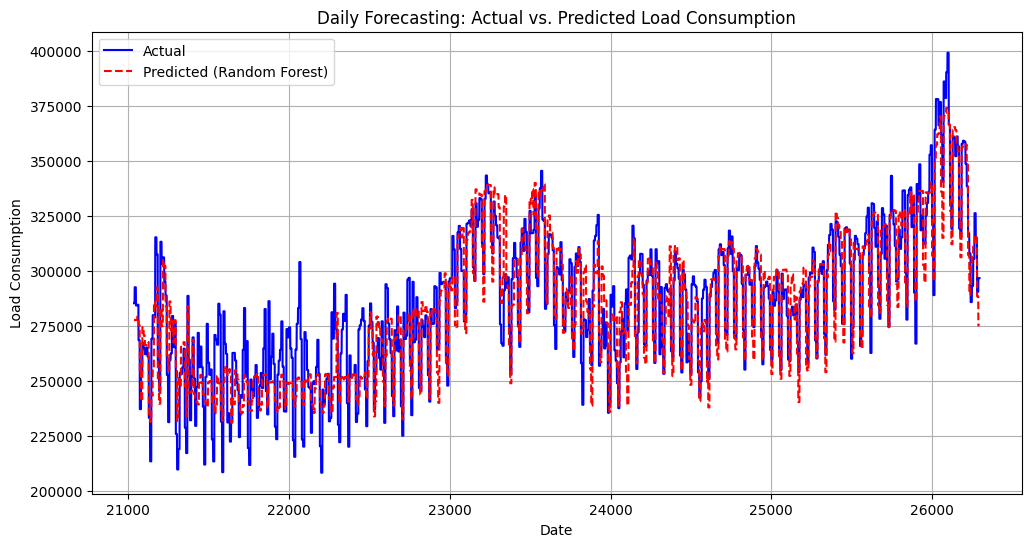

In [207]:
# Create a DataFrame for visualization
df_results = pd.DataFrame({'Actual': y_test_daily, 'Predicted': y_pred_daily}, index=y_test_daily.index)

# Plot Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['Actual'], label="Actual", color="blue", linestyle="-")
plt.plot(df_results.index, df_results['Predicted'], label="Predicted (Random Forest)", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Date")
plt.ylabel("Load Consumption")
plt.title("Daily Forecasting: Actual vs. Predicted Load Consumption")
plt.legend()
plt.grid(True)
plt.show()


### Automaticlly assign features using rfa

In [208]:
# Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    #Print feature importances
    print("Feature Importances (Descending Order):")
    print(feature_importances)
    
    return feature_importances

### LSTM on daily_data

In [211]:
from tensorflow.keras.optimizers import Adam

Epoch 1/50
1314/1314 [==============================] - 40s 29ms/step - loss: 0.1622 - val_loss: 0.1018
Epoch 2/50
1314/1314 [==============================] - 38s 29ms/step - loss: 0.0894 - val_loss: 0.0795
Epoch 3/50
1314/1314 [==============================] - 38s 29ms/step - loss: 0.0769 - val_loss: 0.0634
Epoch 4/50
1314/1314 [==============================] - 40s 30ms/step - loss: 0.0700 - val_loss: 0.0650
Epoch 5/50
1314/1314 [==============================] - 41s 32ms/step - loss: 0.0656 - val_loss: 0.0586
Epoch 6/50
1314/1314 [==============================] - 40s 31ms/step - loss: 0.0629 - val_loss: 0.0651
Epoch 7/50
1314/1314 [==============================] - 42s 32ms/step - loss: 0.0603 - val_loss: 0.0603
Epoch 8/50
1314/1314 [==============================] - 42s 32ms/step - loss: 0.0563 - val_loss: 0.0659
Epoch 9/50
1314/1314 [==============================] - 40s 30ms/step - loss: 0.0529 - val_loss: 0.0614
Epoch 10/50
1314/1314 [==============================] - 40s 31m

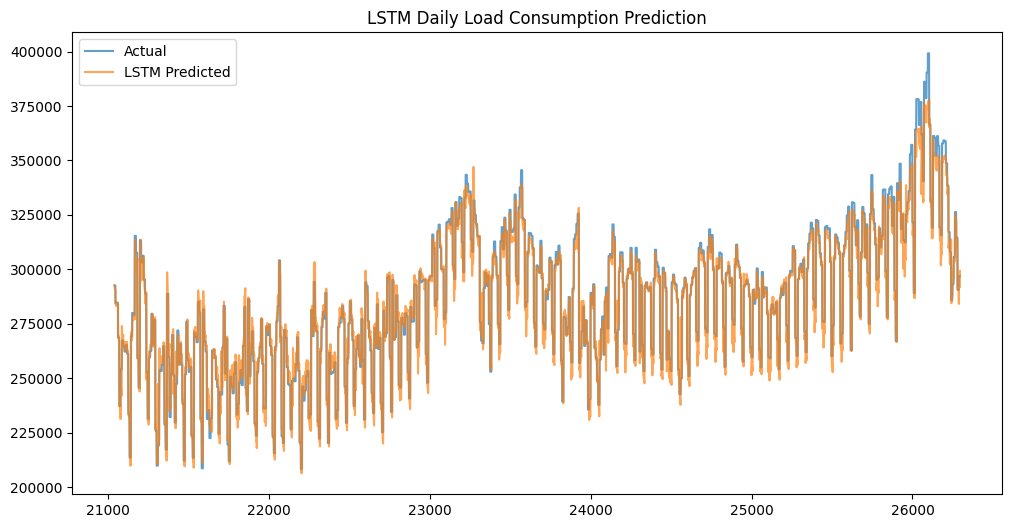

In [212]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Identify and drop any datetime columns
datetime_cols = daily_features.select_dtypes(include=['datetime64']).columns
daily_features = daily_features.drop(columns=datetime_cols)

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back


# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(daily_data.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()
